In [1]:
import pycuda.autoinit
import time
import cv2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm_notebook as tqdm


from utils import read_yaml
from lpr_api.models.plate_detector_trt import PlateDetectorTRT
from lpr_api.models.segmentator_trt import SegmentatorTRT
from lpr_api.models.char_recognizer import CharRecognizer

# Load models

In [28]:
models_cfg = read_yaml('config/models.yaml')
recognizer = CharRecognizer(models_cfg['char_recognizer'])
detector = PlateDetectorTRT(models_cfg['plate_detector_trt'])
segmentator = SegmentatorTRT(models_cfg['segmentator_trt'])

# How much to pad in detected plates before segmenting (0~1)
pad_x = models_cfg['lpr']['pad_x']
pad_y = models_cfg['lpr']['pad_y']

0.1

# Load data

In [3]:
img_paths = []
img_paths.extend(glob.glob('./LRC_frames/*.jpg'))
img_paths.extend(glob.glob('./LRC_frames/*/*.jpg'))
img_paths = [path for path in img_paths if 'NA_' not in path]
print(f'Total number of plates: {len(img_paths)}')

Total number of plates: 174


# Evaluate plate detector performance

In [36]:
num_wrong_plates = 0

plates = {}
for i in tqdm(range(0, len(img_paths), 8)):
    batch_paths = img_paths[i: i+8]
    batch_imgs = [cv2.imread(path) for path in batch_paths]
    batch_coords = detector.predict(batch_imgs)
    for path, img, coords in zip(batch_paths, batch_imgs, batch_coords):
        if len(coords) == 0 or coords is None:
            num_wrong_plates += 1
            continue
        elif len(coords) > 1:
            print(f'multiple plates detected {path}, ignored img')
            continue
        else:
            h, w = img.shape[:2]
            x1, y1, x2, y2, _, _, _ = coords[0].astype('int')
            pad_w = int((x2-x1)*pad_x)
            pad_h = int((y2-y1)*pad_y)
            y1 = int(max(y1-pad_h,0))
            y2 = int(min(y2+pad_h,h))
            x1 = int(max(x1-pad_w,0))
            x2 = int(min(x2+pad_w,w))
            plates[path] = img[y1:y2, x1:x2]
print(f'missed {num_wrong_plates} plates')

multiple plates detected ./LRC_frames/SJ4986_82715.jpg, ignored img

missed 4 plates


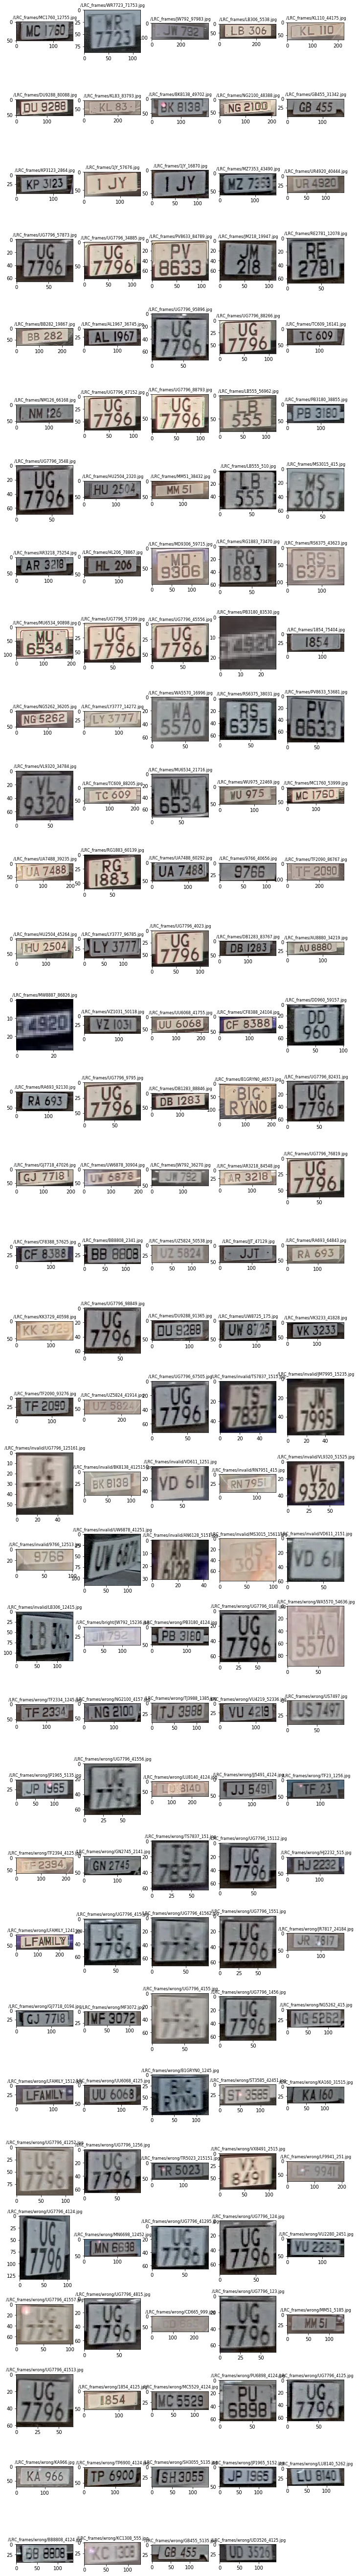

In [37]:
w=10
h=10
fig=plt.figure(figsize=(12, 100))
columns = 5
rows = 35
for i, (path, plate) in enumerate(plates.items()):
    sub_plt = fig.add_subplot(rows, columns, i+1)
    sub_plt.set_title(path, fontsize=8)
    plt.imshow(plate)
plt.show()

In [38]:
num_wrong_plates += int(input('please look above and count wrong sample: '))
print(f'Total of detection missing/wrong = {num_wrong_plates}')
print(f'Acc: {(len(plates)-num_wrong_plates)/len(plates)}')

please look above and count wrong sample: 2
Total of detection missing/wrong = 6
Acc: 0.9644970414201184


In [39]:
# delete wrong plates
del plates['./LRC_frames/PB3180_83530.jpg']
del plates['./LRC_frames/MW8887_86826.jpg']

# Evaluate segmentator performance

In [48]:
num_wrong_seg = 0
ttl_chars = 0

plates = {k: v for k, v in plates.items() if v is not None}
path_plates_lst = list(plates.items())
chars = {}
for i in tqdm(range(0, len(path_plates_lst), 8)):
    batch_paths = [path_plate_tuple[0] for path_plate_tuple in path_plates_lst[i: i+8]]
    batch_plates = [path_plate_tuple[1] for path_plate_tuple in path_plates_lst[i: i+8]]
    batch_coords = segmentator.predict(batch_plates)
    for path, plate, coords in zip(batch_paths, batch_plates, batch_coords):
        gt = get_gt_from_path(path)
        ttl_chars += len(gt)
        # only count missing seg here, wrong seg will be check by hand later
        if coords is None:
            num_wrong_seg += len(gt)
            continue
        if len(coords) < len(gt):
            num_wrong_seg += (len(gt) - len(coords))
        chars_lst = []
        for coord in coords:
            x1, y1, x2, y2 = coord.astype('int')
            y1 = int(y1)-2
            y2 = int(y2)+2
            x1 = int(x1)-2
            x2 = int(x2)+2

            # Avoid out of boundary of image
            y1 = max(0,y1)
            y2 = max(0,y2)
            x1 = max(0,x1)
            x2 = max(0,x2)
            y1 = min(plate.shape[0],y1)
            y2 = min(plate.shape[0],y2)
            x1 = min(plate.shape[1],x1)
            x2 = min(plate.shape[1],x2)
            
            chars_lst.append(plate[y1:y2, x1:x2])
        chars[path] = chars_lst
print(f'missed {num_wrong_seg} chars')


missed 19 chars


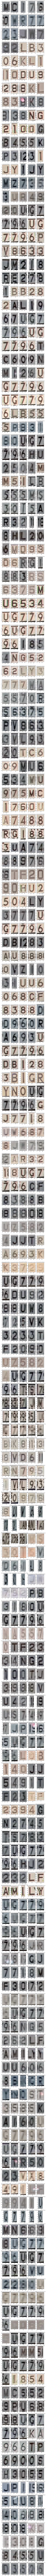

In [49]:
w=10
h=10
fig=plt.figure(figsize=(12, 800))
columns = 5
rows = 200
i = 0
for path, char_lst in chars.items():
    for char in char_lst:
        sub_plt = fig.add_subplot(rows, columns, i+1)
        sub_plt.set_title(path, fontsize=8)
        plt.imshow(char)
        i += 1
plt.show()

In [51]:
num_wrong_seg += int(input('please look above and count wrong sample: '))
print(f'Total of segmentation missing/wrong = {num_wrong_seg}')
print(f'Acc: {(ttl_chars-num_wrong_seg)/ttl_chars}')

please look above and count wrong sample: 6
Total of segmentation missing/wrong = 25
Acc: 0.9741735537190083


In [52]:
# supposed needa delete wrong seg
# but it will need to delete gt char coorespondingly, too crazy,
# so just ignore wrong seg and let's test on recogniser directly

# Evaluate recogniser performance

In [53]:
def get_gt_from_path(path):
    return path.split('/')[-1].split('_')[0]

In [69]:
num_wrong_recog = 0
num_chars = 0
wrong_char_img_lst = []
for path, char_lst in tqdm(chars.items(), total=len(chars)):
    gt = get_gt_from_path(path)
    pred, conf = recognizer.predict(char_lst)
    num_chars += len(pred)
    for pred_char, gt_char, char_img in zip(pred, gt, char_lst):
        if pred_char != gt_char:
            num_wrong_recog += 1
            wrong_char_img_lst.append(char_img)
print(f'recognition wrong: {num_wrong_recog}/{num_chars}')
print(f'acc: {(num_chars-num_wrong_recog)/num_chars}')


recognition wrong: 87/950
acc: 0.9084210526315789


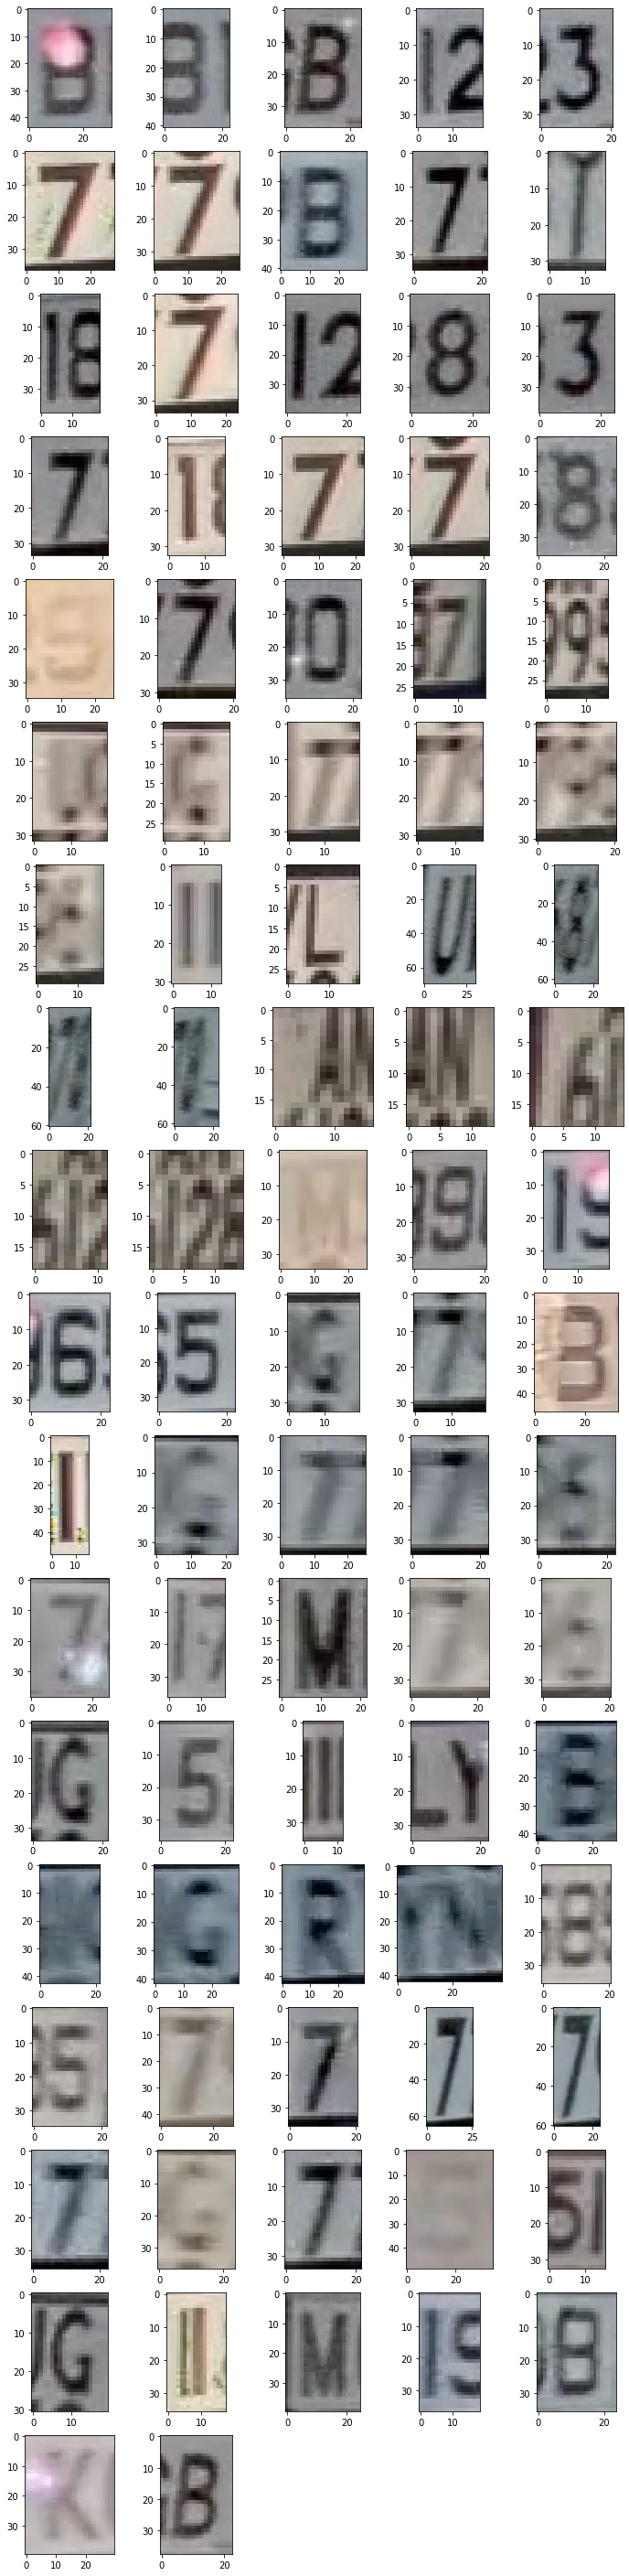

In [70]:
w=10
h=10
fig=plt.figure(figsize=(12, 100))
columns = 5
rows = 35
for i, char in enumerate(wrong_char_img_lst):
    sub_plt = fig.add_subplot(rows, columns, i+1)
    plt.imshow(char)
plt.show()